In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, concatenate, Input, Resizing, SpatialDropout2D, BatchNormalization, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
import tensorflow as tf
from tensorflow.keras.layers import Input, UpSampling2D, Conv2D, SpatialDropout2D, BatchNormalization, Activation, concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import json
import uuid
from tensorflow.keras import mixed_precision
from datetime import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Input, Resizing, Dropout, BatchNormalization, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
# Set the policy to mixed_float16
mixed_precision.set_global_policy('mixed_float16')


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Laptop GPU, compute capability 8.6


In [3]:
# Configure GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and being used.")
    except RuntimeError as e:
        print(e)
else:
    print("GPU is not available. Using CPU.")

GPU is available and being used.


In [4]:
# Cell 5: Set base directory and batch size
base_dir = 'E:\\study\\graduation\\vitiligo-assessment\\data'


In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, base_dir, data_type='train', batch_size=8, img_size=(256, 256), shuffle=True, augment=False):
        self.base_dir = base_dir
        self.data_type = data_type
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.image_dir = os.path.join(base_dir, data_type, 'images')
        self.mask_dir = os.path.join(base_dir, data_type, 'masks')
        self.file_list = self.load_dataset()
        self.on_epoch_end()
        print(f"File list type: {type(self.file_list)}, length: {len(self.file_list)}")

    def load_dataset(self):
        image_files = os.listdir(self.image_dir)
        mask_files = os.listdir(self.mask_dir)
        return list(image_files)  # Ensure this returns a list

    def __len__(self):
        return len(self.file_list) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_file_list = [self.file_list[k] for k in indexes]
        images, masks = self.__data_generation(batch_file_list)
        return images, masks

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.file_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def _parse_function(self, filename):
        image_path = os.path.join(self.image_dir, filename)
        mask_path = os.path.join(self.mask_dir, filename.replace('.jpg', '_mask.png'))
        try:
            image = tf.io.read_file(image_path)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.resize(image, self.img_size)
            image = tf.cast(image, tf.float32) / 255.0
            mask = tf.io.read_file(mask_path)
            mask = tf.image.decode_png(mask, channels=1)
            mask = tf.image.resize(mask, self.img_size)
            mask = tf.cast(mask, tf.float32) / 255.0
            if image.shape != (self.img_size[0], self.img_size[1], 3) or mask.shape != (self.img_size[0], self.img_size[1], 1):
                raise ValueError(f"Incorrect shape for image or mask. Image shape: {image.shape}, Mask shape: {mask.shape}")
            return image, mask
        except Exception as e:
            print(f"Error parsing file {filename}: {e}")
            return None, None

    def _augment_function(self, image, mask):
        if tf.random.uniform([]) > 0.5:
            image = tf.image.flip_left_right(image)
            mask = tf.image.flip_left_right(mask)
        if tf.random.uniform([]) > 0.5:
            image = tf.image.flip_up_down(image)
            mask = tf.image.flip_up_down(mask)
        k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k=k)
        mask = tf.image.rot90(mask, k=k)
        scales = tf.random.uniform([], minval=0.8, maxval=1.2, dtype=tf.float32)
        size = tf.shape(image)[0:2]
        new_size = tf.cast(tf.cast(size, tf.float32) * scales, tf.int32)
        image = tf.image.resize(image, new_size)
        mask = tf.image.resize(mask, new_size)
        image = tf.image.resize_with_crop_or_pad(image, size[0], size[1])
        mask = tf.image.resize_with_crop_or_pad(mask, size[0], size[1])
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
        image = tf.image.random_hue(image, max_delta=0.1)
        image = tf.clip_by_value(image, 0.0, 1.0)
        mask = tf.clip_by_value(mask, 0, 1)
        mask = tf.cast(mask > 0.5, tf.float32)
        return image, mask

    def __data_generation(self, batch_file_list):
        images = []
        masks = []
        for filename in batch_file_list:
            image, mask = self._parse_function(filename)
            if image is not None and mask is not None:
                if self.augment:
                    image, mask = self._augment_function(image, mask)
                images.append(image)
                masks.append(mask)
        return np.array(images), np.array(masks)

    def collect_all_masks(self):
        masks = []
        for filename in self.file_list:
            _, mask = self._parse_function(filename)
            if mask is not None:
                masks.append(mask)
        return np.array(masks)


In [6]:
# train_generator = DataGenerator(base_dir, data_type='train', batch_size=8, img_size=(256, 256), shuffle=True, augment=True)
# val_generator = DataGenerator(base_dir, data_type='valid', batch_size=8, img_size=(256, 256), shuffle=False, augment=False)

In [7]:
# Cell 4: Set base directory and batch size
base_dir = 'E:\\study\\graduation\\vitiligo-assessment\\data'

In [8]:
# import matplotlib.pyplot as plt

# def visualize_data(generator, title, num_images=5):
#     fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
#     for i in range(num_images):
#         image, mask = generator[i]
#         axes[i].imshow(image[0])
#         axes[i].set_title(title)
#         axes[i].axis('off')
#     plt.show()

# # Visualize training data
# visualize_data(train_generator, 'Training Data')

# # Visualize validation data
# visualize_data(val_generator, 'Validation Data')

# # Visualize augmented data
# train_generator_with_aug = DataGenerator(base_dir, data_type='train', batch_size=1, img_size=(256, 256), shuffle=True, augment=True)
# visualize_data(train_generator_with_aug, 'Augmented Data')


In [9]:
from keras.applications import InceptionResNetV2
from keras.layers import Input, Conv2D, UpSampling2D, BatchNormalization, Activation, Dropout, concatenate, Resizing
from keras.regularizers import l2
from keras.models import Model
from keras.optimizers import Adam

def add_regularization(model, regularizer):
    if not isinstance(regularizer, l2):
        raise ValueError("Only L2 regularization is supported.")
    
    for layer in model.layers:
        if isinstance(layer, Conv2D):
            layer.kernel_regularizer = regularizer

    return model

def unet_with_inceptionresnetv2(input_size=(256, 256, 3), pretrained=True):
    inception = InceptionResNetV2(include_top=False, weights='imagenet' if pretrained else None, input_shape=input_size)
    for layer in inception.layers[:-150]:
        layer.trainable = False

    inception = add_regularization(inception, l2(0.001))
    
    contract_path = inception.get_layer('mixed_6a').output
    block35_10_conv_output = inception.get_layer('block35_10_conv').output
    block35_10_conv_output = UpSampling2D(size=(4, 4))(block35_10_conv_output)
    block35_10_conv_output = Resizing(contract_path.shape[1]*2, contract_path.shape[2]*2)(block35_10_conv_output)

    up = UpSampling2D((2, 2))(contract_path)
    up = concatenate([up, block35_10_conv_output], axis=-1)
    up = Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.001))(up)
    up = Dropout(0.5)(up)
    up = BatchNormalization()(up)
    up = Activation('relu')(up)
    up = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001))(up)
    up = Dropout(0.5)(up)
    up = BatchNormalization()(up)
    up = Activation('relu')(up)
    up = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.001))(up)
    up = Dropout(0.5)(up)
    up = BatchNormalization()(up)
    up = Activation('relu')(up)
    up = UpSampling2D((2, 2))(up)
    up = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001))(up)
    up = Dropout(0.5)(up)
    up = BatchNormalization()(up)
    up = Activation('relu')(up)
    up = UpSampling2D((2, 2))(up)
    up = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.001))(up)
    up = Dropout(0.5)(up)
    up = BatchNormalization()(up)
    up = Activation('relu')(up)
    up = Resizing(256, 256)(up)

    final = Conv2D(1, (1, 1), activation='sigmoid', dtype='float32')(up)
    model = Model(inputs=inception.input, outputs=final)
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Example usage
model = unet_with_inceptionresnetv2()
# model.summary()


In [10]:
def add_regularization(model, regularizer):
    if not isinstance(regularizer, l2):
        raise ValueError("Only L2 regularization is supported.")
    
    for layer in model.layers:
        if isinstance(layer, Conv2D):
            layer.kernel_regularizer = regularizer

    return model

In [11]:
# for layer in model.layers:
#     if isinstance(layer, Conv2D):
#         print(f"{layer.name} - Kernel Regularizer: {layer.kernel_regularizer}")
#     elif isinstance(layer, Dropout):
#         print(f"{layer.name} - Dropout Rate: {layer.rate}")
#     elif isinstance(layer, BatchNormalization):
#         print(f"{layer.name} - BatchNormalization Layer")


In [12]:
# def inspect_model_regularization(model):
#     for layer in model.layers:
#         if isinstance(layer, Conv2D):
#             print(f"{layer.name} - Kernel Regularizer: {layer.kernel_regularizer}")
#         elif isinstance(layer, Dropout):
#             print(f"{layer.name} - Dropout Rate: {layer.rate}")
#         elif isinstance(layer, BatchNormalization):
#             print(f"{layer.name} - BatchNormalization Layer")

# inspect_model_regularization(model)


In [13]:
# plot_model(model, to_file='contracting_path.png', show_shapes=True, show_layer_names=True, dpi=150, expand_nested=True)


In [14]:
# plot_model(model, to_file='expanding_path.png', show_shapes=True, show_layer_names=True, dpi=150, expand_nested=True)


In [15]:
    # Define loss functions and necessary callbacks
    def combined_tversky_loss(y_true, y_pred, alpha=0.5, beta=0.5, gamma=1.0):
        y_true = tf.ensure_shape(y_true, [None, 256, 256, 1])
        y_pred = tf.ensure_shape(y_pred, [None, 256, 256, 1])
        
        if y_true.shape != y_pred.shape:
            raise ValueError(f"Shape mismatch: y_true shape {y_true.shape}, y_pred shape {y_pred.shape}")
        
        true_pos = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
        false_neg = tf.reduce_sum(y_true * (1 - y_pred), axis=[1, 2, 3])
        false_pos = tf.reduce_sum((1 - y_true) * y_pred, axis=[1, 2, 3])
        
        tversky_index = (true_pos + 1) / (true_pos + alpha * false_neg + beta * false_pos + 1)
        loss = tf.reduce_mean((1 - tversky_index) ** gamma)
        
        return loss
    
    def combined_tversky_loss_with_weights(weights):
        def loss(y_true, y_pred):
            return combined_tversky_loss(y_true, y_pred, weights[0], weights[1])
        return loss
    
    def compute_class_weights(y_true):
        y_true_flat = tf.reshape(y_true, [-1])
        total_pixels = tf.size(y_true_flat, out_type=tf.float32)
        pos_pixels = tf.reduce_sum(tf.cast(y_true_flat, tf.float32))
        neg_pixels = total_pixels - pos_pixels
        weight_for_0 = neg_pixels / total_pixels
        weight_for_1 = pos_pixels / total_pixels
        class_weights = [weight_for_0.numpy(), weight_for_1.numpy()]
        return class_weights
    
    def iou_metric(y_true, y_pred):
        y_true = tf.cast(y_true > 0.5, tf.float32)
        y_pred = tf.cast(y_pred > 0.5, tf.float32)
        intersection = tf.reduce_sum(y_true * y_pred)
        union = tf.reduce_sum(y_true + y_pred) - intersection
        return intersection / (union + tf.keras.backend.epsilon())
    
    def dice_coefficient(y_true, y_pred):
        y_true = tf.cast(y_true > 0.5, tf.float32)
        y_pred = tf.cast(y_pred > 0.5, tf.float32)
        intersection = tf.reduce_sum(y_true * y_pred)
        return (2. * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())
    
    class HistoryCallback(Callback):
        def __init__(self, history_save_path, log_dir):
            super().__init__()
            self.history_save_path = history_save_path
            self.log_dir = log_dir
    
        def on_epoch_end(self, epoch, logs=None):
            logs = logs or {}
            logs = {k: float(v) if isinstance(v, (int, float)) else str(v) for k, v in logs.items()}
            with open(self.history_save_path, 'a') as f:
                json.dump({epoch: logs}, f)
                f.write("\n")
            # Debug print to check if logging is working
            print(f"Epoch {epoch} logs: {logs}")


In [16]:
# Set random seed and define paths
base_dir = 'E:\\study\\graduation\\vitiligo-assessment\\data'
save_dir = 'E:\\study\\graduation\\vitiligo-assessment\\models\\unet_with_inceptionresnetv2'
log_dir = 'E:\\study\\graduation\\vitiligo-assessment\\logs\\unet_with_inceptionresnetv2'
history_save_path = os.path.join(save_dir, 'training_histories.json')

def set_random_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_random_seed(42)

In [17]:
# class WarmupExponentialDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
#     def __init__(self, initial_learning_rate, warmup_steps, decay_steps, decay_rate):
#         super(WarmupExponentialDecay, self).__init__()
#         self.initial_learning_rate = initial_learning_rate
#         self.warmup_steps = warmup_steps
#         self.decay_steps = decay_steps
#         self.decay_rate = decay_rate

#     def __call__(self, step):
#         initial_learning_rate = tf.convert_to_tensor(self.initial_learning_rate, name="initial_learning_rate")
#         dtype = initial_learning_rate.dtype

#         warmup_steps_const = tf.constant(self.warmup_steps, dtype=dtype)
#         step = tf.cast(step, dtype)

#         warmup_lr = self.initial_learning_rate * (step / warmup_steps_const)
#         decay_lr = self.initial_learning_rate * tf.math.pow(
#             self.decay_rate, 
#             (step - warmup_steps_const) / tf.cast(self.decay_steps, dtype)
#         )

#         learning_rate = tf.cond(step < warmup_steps_const, lambda: warmup_lr, lambda: decay_lr)

#         return learning_rate


In [18]:
# # Learning rate schedule with warm-up and exponential decay
# initial_learning_rate = 1e-4
# warmup_steps = 500
# decay_steps = 10000
# decay_rate = 0.95

# learning_rate_schedule = WarmupExponentialDecay(
#     initial_learning_rate=initial_learning_rate, 
#     warmup_steps=warmup_steps, 
#     decay_steps=decay_steps, 
#     decay_rate=decay_rate
# )



In [19]:
os.makedirs(save_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

history_callback = HistoryCallback(history_save_path, log_dir)

In [20]:
def create_optimizer():
    base_optimizer = Adam(learning_rate=0.001)

    # Check if mixed precision is enabled
    if tf.config.experimental.list_physical_devices('GPU'):
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)

        # Check if the optimizer is already wrapped
        if not isinstance(base_optimizer, tf.keras.mixed_precision.LossScaleOptimizer):
            optimizer = tf.keras.mixed_precision.LossScaleOptimizer(base_optimizer)
        else:
            optimizer = base_optimizer
    else:
        optimizer = base_optimizer
    
    return optimizer

In [21]:
def get_optimizer_name(optimizer):
    if isinstance(optimizer, tf.keras.mixed_precision.LossScaleOptimizer):
        return optimizer._optimizer.__class__.__name__
    else:
        return optimizer.__class__.__name__

In [22]:
def test_optimizer_compilation():
    try:
        # Create a dummy model for compilation test
        input_tensor = tf.keras.Input(shape=(256, 256, 3))
        dummy_output = tf.keras.layers.Conv2D(1, (3, 3), padding='same')(input_tensor)
        dummy_model = tf.keras.Model(inputs=input_tensor, outputs=dummy_output)
        
        # Compile the model with the optimizer
        dummy_model.compile(optimizer=create_optimizer(), loss='mse')
        print(f"Optimizer compilation successful with {get_optimizer_name(create_optimizer())}")
    except Exception as e:
        print(f"Optimizer compilation failed: {str(e)}")

In [23]:
# # Create data generators
# batch_size = 16
# input_size = (256, 256)

In [26]:
# Example usage
train_dir = "E:\\study\\graduation\\vitiligo-assessment\\data"
val_dir = "E:\\study\\graduation\\vitiligo-assessment\\data"
# Initialize Data Generators
# train_generator = DataGenerator(base_dir=train_dir, data_type='train', batch_size=batch_size, img_size=input_size)
# val_generator = DataGenerator(base_dir=val_dir, data_type='valid', batch_size=batch_size, img_size=input_size)


In [ ]:
model = unet_with_inceptionresnetv2()
optimizer = create_optimizer()

In [25]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

batch_size = 8
results[batch_size] = {}

best_weights = None

for fold_index, (train_index, val_index) in enumerate(kf.split(np.arange(len(os.listdir(os.path.join(base_dir, 'train', 'images')))))):
    # Data generators
    train_generator = DataGenerator(base_dir, data_type='train', batch_size=batch_size, img_size=(256, 256), shuffle=True, augment=True)
    val_generator = DataGenerator(base_dir, data_type='valid', batch_size=batch_size, img_size=(256, 256), shuffle=False, augment=False)

    # Model initialization
    model = unet_with_inceptionresnetv2()
    if best_weights:
        status = model.load_weights(best_weights)
        status.expect_partial()  # Silences the warnings

    # Compute class weights
    y_true = np.array(train_generator.collect_all_masks())
    y_true_tensor = tf.convert_to_tensor(y_true, dtype=tf.float32)
    class_weights = compute_class_weights(y_true_tensor)

    # Re-create the optimizer for each fold to ensure it is fresh
    optimizer = create_optimizer()
    opt_name = get_optimizer_name(optimizer)
    results[batch_size][opt_name] = []

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss=combined_tversky_loss_with_weights(class_weights),
                  metrics=['accuracy', iou_metric, dice_coefficient])

    # Setup callbacks
    unique_id = datetime.now().strftime("%Y%m%d%H%M%S") + "_" + uuid.uuid4().hex
    checkpoint_path = os.path.join(save_dir, f'unet_inceptionresnetv2_bs{batch_size}_opt{opt_name}_fold{fold_index}_{unique_id}')
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1, save_freq='epoch', mode='auto', save_weights_only=True, save_format='tf')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)

    # Train the model
    history = model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=100,
                        callbacks=[checkpoint, early_stopping, history_callback, reduce_lr])

    # Store training history
    history_serializable = {k: [float(v) for v in values] for k, values in history.history.items()}
    results[batch_size][opt_name].append(history_serializable)

    best_weights = checkpoint_path

    # Fine-tuning
    for layer in model.layers[-50:]:
        layer.trainable = True

    # Recompile the model for fine-tuning
    fine_tune_optimizer = Adam(learning_rate=1e-5)
    model.compile(optimizer=fine_tune_optimizer,
                  loss=combined_tversky_loss_with_weights(class_weights),
                  metrics=['accuracy', iou_metric, dice_coefficient])

    fine_tune_checkpoint_path = os.path.join(save_dir, f'unet_inceptionresnetv2_finetune_bs{batch_size}_opt{opt_name}_fold{fold_index}_{unique_id}')
    fine_tune_early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    fine_tune_checkpoint = ModelCheckpoint(fine_tune_checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1, save_freq='epoch', mode='auto', save_weights_only=True, save_format='tf')

    fine_tune_history = model.fit(train_generator,
                                  validation_data=val_generator,
                                  epochs=30,
                                  callbacks=[fine_tune_checkpoint, fine_tune_early_stopping, history_callback, reduce_lr])

    best_weights = fine_tune_checkpoint_path

    # Save the complete model
    model_save_path = os.path.join(save_dir, f'unet_with_inceptionresnetv2_complete_model_bs{batch_size}_opt{opt_name}_fold{fold_index}_{unique_id}.h5')
    if os.path.exists(model_save_path):
        os.remove(model_save_path)

    # Recompile and save the final model
    temp_optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=temp_optimizer,
                  loss=combined_tversky_loss_with_weights(class_weights),
                  metrics=['accuracy', iou_metric, dice_coefficient])

    model.save(model_save_path)
    print(f"Finished fold {fold_index + 1} of {kf.n_splits}.")


File list type: <class 'list'>, length: 3034
File list type: <class 'list'>, length: 778
Epoch 1/100
379/379 [==============================] - ETA: 0s - loss: 0.4116 - accuracy: 0.7169 - iou_metric: 0.5720 - dice_coefficient: 0.7240
Epoch 1: val_loss improved from inf to 0.69823, saving model to E:\study\graduation\vitiligo-assessment\models\unet_with_inceptionresnetv2\unet_inceptionresnetv2_bs8_optAdam_fold0_20240604023335_ba7528d6e9b046a09d34751c56fc6209
Epoch 0 logs: {'loss': 0.4115521013736725, 'accuracy': 0.7168753147125244, 'iou_metric': 0.5720152258872986, 'dice_coefficient': 0.7240088582038879, 'val_loss': 0.6982295513153076, 'val_accuracy': 0.6352362036705017, 'val_iou_metric': 0.22645358741283417, 'val_dice_coefficient': 0.3554264307022095}
379/379 [==============================] - 94s 230ms/step - loss: 0.4116 - accuracy: 0.7169 - iou_metric: 0.5720 - dice_coefficient: 0.7240 - val_loss: 0.6982 - val_accuracy: 0.6352 - val_iou_metric: 0.2265 - val_dice_coefficient: 0.3554 

In [18]:
test_generator = DataGenerator(base_dir, data_type='test', batch_size=16, img_size=(256, 256), shuffle=False, augment=False)


In [19]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

# Define the custom loss and metric functions
def combined_tversky_loss(y_true, y_pred, alpha=0.5, beta=0.5, gamma=1.0):
    y_true = tf.ensure_shape(y_true, [None, 256, 256, 1])
    y_pred = tf.ensure_shape(y_pred, [None, 256, 256, 1])
    
    if y_true.shape != y_pred.shape:
        raise ValueError(f"Shape mismatch: y_true shape {y_true.shape}, y_pred shape {y_pred.shape}")
    
    true_pos = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    false_neg = tf.reduce_sum(y_true * (1 - y_pred), axis=[1, 2, 3])
    false_pos = tf.reduce_sum((1 - y_true) * y_pred, axis=[1, 2, 3])
    
    tversky_index = (true_pos + 1) / (true_pos + alpha * false_neg + beta * false_pos + 1)
    loss = tf.reduce_mean((1 - tversky_index) ** gamma)
    
    return loss

def combined_tversky_loss_with_weights(weights):
    def loss(y_true, y_pred):
        return combined_tversky_loss(y_true, y_pred, weights[0], weights[1])
    return loss

def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred) - intersection
    return intersection / (union + tf.keras.backend.epsilon())

def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())

# Define the class weights
class_weights = [0.5, 0.5]

# Create a specific instance of the loss function with the given weights
loss_instance = combined_tversky_loss_with_weights(class_weights)


In [52]:
# Load the model
model_path = 'E:\study\\graduation\\vitiligo-assessment\\models\\unet_with_inceptionresnetv2\\unet_with_inceptionresnetv2_complete_model_bs8_optAdam_fold4_20240601091555_fa75d2b2b9aa44c7a9687c52a2d6db56.h5'
model = load_model(model_path, custom_objects={
    'combined_tversky_loss': combined_tversky_loss,
    'loss': loss_instance,  # This ensures the correct instance is passed
    'iou_metric': iou_metric,
    'dice_coefficient': dice_coefficient
})

# Compile the model with the same loss and metrics
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=loss_instance,
              metrics=['accuracy', iou_metric, dice_coefficient])


In [53]:
# Prepare the test data
test_dir = 'E:\\study\\graduation\\vitiligo-assessment\\data\\test'
test_images = [os.path.join(test_dir, 'images', f) for f in os.listdir(os.path.join(test_dir, 'images'))]
test_masks = [os.path.join(test_dir, 'masks', f) for f in os.listdir(os.path.join(test_dir, 'masks'))]


def load_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    img = img / 255.0
    return img

def load_mask(file_path):
    mask = tf.io.read_file(file_path)
    mask = tf.image.decode_image(mask, channels=1)
    mask = tf.image.resize(mask, [256, 256])
    mask = mask / 255.0
    return mask

test_images = np.array([load_image(img) for img in test_images])
test_masks = np.array([load_mask(mask) for mask in test_masks])


In [54]:
# Evaluate the model on the test data
results = model.evaluate(test_images, test_masks, batch_size=8)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")
print(f"Test IoU Metric: {results[2]}")
print(f"Test Dice Coefficient: {results[3]}")


31/31 [==============================] - 2s 23ms/step - loss: 0.2469 - accuracy: 0.8171 - iou_metric: 0.6613 - dice_coefficient: 0.7924
Test Loss: 0.2469235509634018
Test Accuracy: 0.8171401023864746
Test IoU Metric: 0.6612736582756042
Test Dice Coefficient: 0.7924349308013916


8/8 [==============================] - 1s 46ms/step


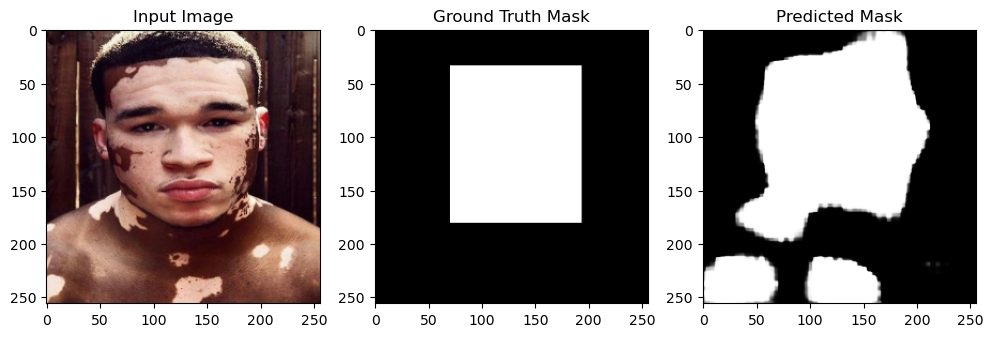

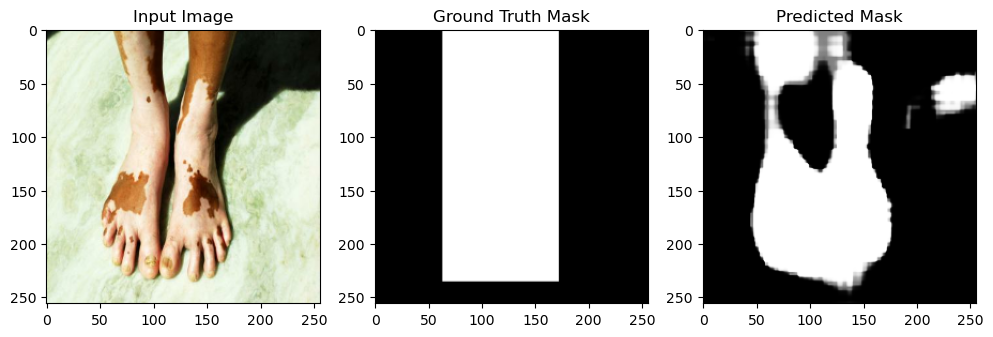

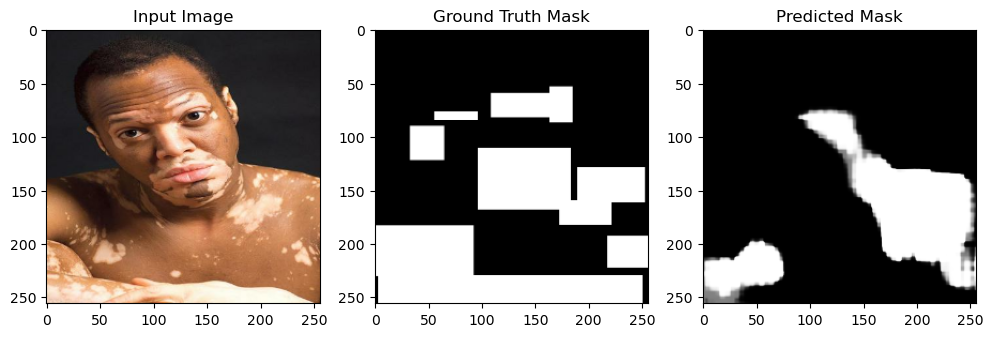

In [55]:
# Predict the masks for the test images
predicted_masks = model.predict(test_images)

# Visualize some sample results
for i in range(3):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(test_images[i])
    plt.title('Input Image')
    
    plt.subplot(1, 3, 2)
    plt.imshow(test_masks[i, :, :, 0], cmap='gray')
    plt.title('Ground Truth Mask')
    
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_masks[i, :, :, 0], cmap='gray')
    plt.title('Predicted Mask')
    
    plt.show()


1/1 [==============================] - 0s 102ms/step


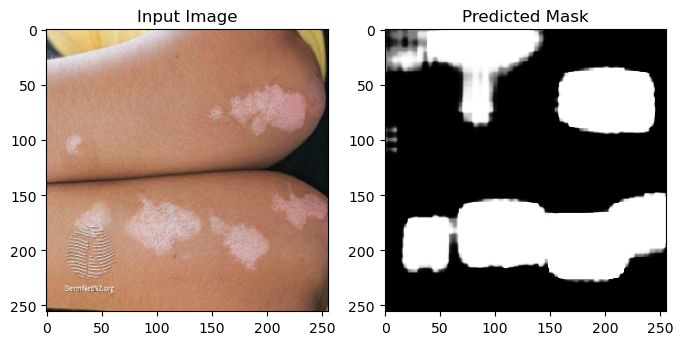

In [56]:
# Load and preprocess a new image for prediction
def load_and_preprocess_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    img = img / 255.0  # Normalize to [0, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Corrected file path with raw string notation
new_image_path = r"E:\study\graduation\Dataset\DermNet\vitiligo-0010__WatermarkedWyJXYXRlcm1hcmtlZCJd.jpg"
new_image = load_and_preprocess_image(new_image_path)

# Predict mask for the new image
predicted_mask = model.predict(new_image)[0]

# Visualize the input image and the predicted mask
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(new_image[0])
plt.title('Input Image')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask[:, :, 0], cmap='gray')
plt.title('Predicted Mask')

plt.show()


8/8 [==============================] - 0s 47ms/step


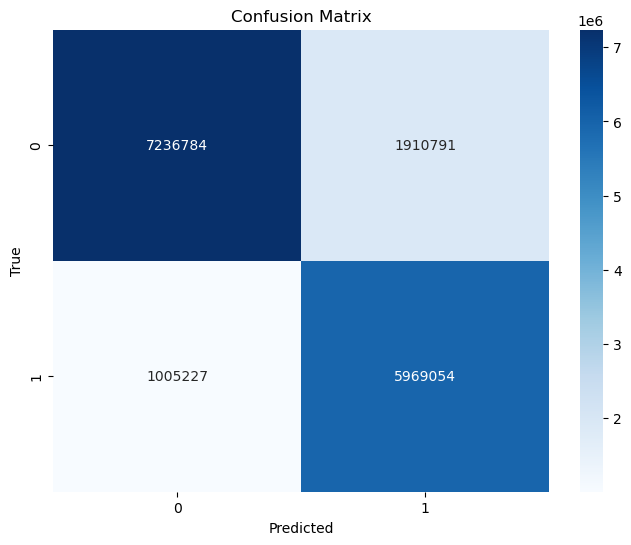

In [57]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have your model and test data loaded
# model: your trained model
# test_images: your test images
# test_masks: your ground truth masks for the test images

# Predict on the test images
y_pred = model.predict(test_images)
y_pred = (y_pred > 0.5).astype(np.uint8)  # Convert probabilities to binary masks

# Flatten the arrays for confusion matrix computation
y_true_flat = test_masks.flatten()
y_pred_flat = y_pred.flatten()

# Ensure y_true is binary
y_true_flat = (y_true_flat > 0.5).astype(np.uint8)

# Compute the confusion matrix
conf_mat = confusion_matrix(y_true_flat, y_pred_flat)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


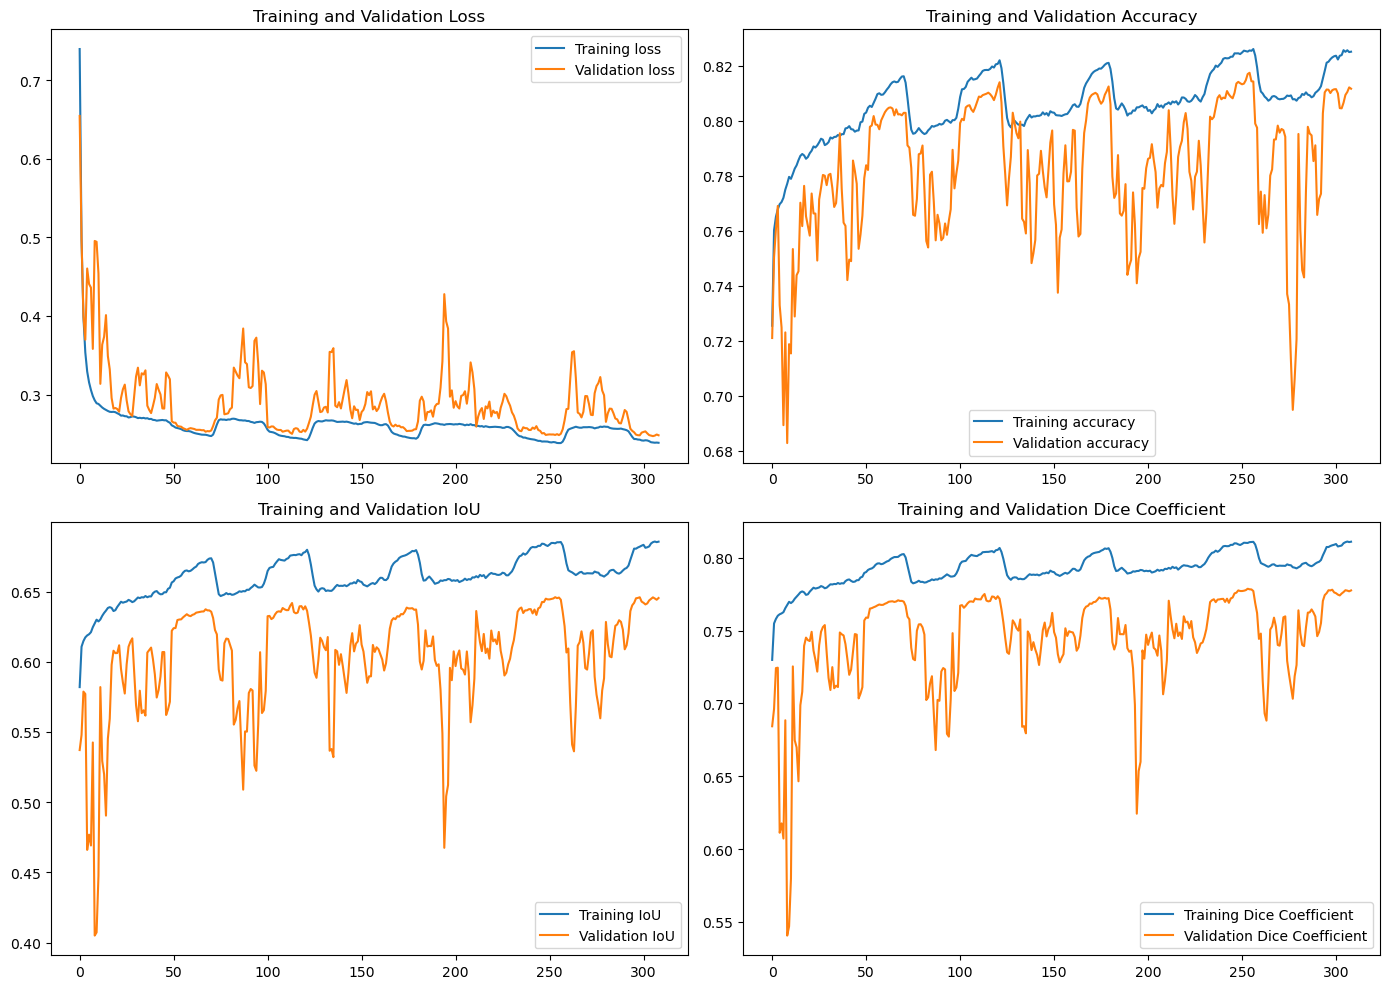

In [58]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load JSON lines from the file
file_path = "E:/study/graduation/vitiligo-assessment/models/unet_with_inceptionresnetv2/training_histories.json"
history = []
with open(file_path, 'r') as f:
    for line in f:
        history.append(json.loads(line.strip()))

# Aggregate the data
history_dict = {
    'loss': [h[list(h.keys())[0]]['loss'] for h in history],
    'val_loss': [h[list(h.keys())[0]]['val_loss'] for h in history],
    'accuracy': [h[list(h.keys())[0]]['accuracy'] for h in history],
    'val_accuracy': [h[list(h.keys())[0]]['val_accuracy'] for h in history],
    'iou_metric': [h[list(h.keys())[0]]['iou_metric'] for h in history],
    'val_iou_metric': [h[list(h.keys())[0]]['val_iou_metric'] for h in history],
    'dice_coefficient': [h[list(h.keys())[0]]['dice_coefficient'] for h in history],
    'val_dice_coefficient': [h[list(h.keys())[0]]['val_dice_coefficient'] for h in history]
}

# Function to compute moving average
def moving_average(data, window_size):
    if window_size > len(data):
        window_size = len(data)
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 3

# Apply moving average to smooth the data
smoothed_history_dict = {
    'loss': moving_average(history_dict['loss'], window_size),
    'val_loss': moving_average(history_dict['val_loss'], window_size),
    'accuracy': moving_average(history_dict['accuracy'], window_size),
    'val_accuracy': moving_average(history_dict['val_accuracy'], window_size),
    'iou_metric': moving_average(history_dict['iou_metric'], window_size),
    'val_iou_metric': moving_average(history_dict['val_iou_metric'], window_size),
    'dice_coefficient': moving_average(history_dict['dice_coefficient'], window_size),
    'val_dice_coefficient': moving_average(history_dict['val_dice_coefficient'], window_size)
}

# Plot training and validation metrics
epochs = range(len(smoothed_history_dict['iou_metric']))

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, smoothed_history_dict['loss'], label='Training loss')
plt.plot(epochs, smoothed_history_dict['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, smoothed_history_dict['accuracy'], label='Training accuracy')
plt.plot(epochs, smoothed_history_dict['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, smoothed_history_dict['iou_metric'], label='Training IoU')
plt.plot(epochs, smoothed_history_dict['val_iou_metric'], label='Validation IoU')
plt.title('Training and Validation IoU')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, smoothed_history_dict['dice_coefficient'], label='Training Dice Coefficient')
plt.plot(epochs, smoothed_history_dict['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.title('Training and Validation Dice Coefficient')
plt.legend()

plt.tight_layout()
plt.show()


In [62]:
import pandas as pd

# Metrics for each model
data = {
    'Model': ['U-Net with ResNet50', 'U-Net with InceptionResNetV2', 'U-Net with EfficientNetB0'],
    'Test Loss': [0.2408, 0.246924, 0.2566935122013092],
    'Test Accuracy': [0.8206, 0.817140, 0.8152041435241699],
    'Test IoU Metric': [0.6719, 0.661274, 0.6511186957359314],
    'Test Dice Coefficient': [0.7920, 0.792435, 0.7837628126144409]
}

metrics_df = pd.DataFrame(data)
print(metrics_df)


                          Model  Test Loss  Test Accuracy  Test IoU Metric  \
0           U-Net with ResNet50   0.240800       0.820600         0.671900   
1  U-Net with InceptionResNetV2   0.246924       0.817140         0.661274   
2     U-Net with EfficientNetB0   0.256694       0.815204         0.651119   

   Test Dice Coefficient  
0               0.792000  
1               0.792435  
2               0.783763  


In [63]:
from scipy.stats import ttest_rel, wilcoxon

# Assuming metrics_df contains the metrics for each model
# Extracting IoU and Dice coefficients for paired comparisons
iou_metrics = metrics_df['Test IoU Metric']
dice_metrics = metrics_df['Test Dice Coefficient']

# Perform paired t-test
t_stat_iou, p_value_iou = ttest_rel(iou_metrics, dice_metrics)
print(f'Paired t-test for IoU vs Dice Coefficient: t-statistic={t_stat_iou}, p-value={p_value_iou}')

# Perform Wilcoxon signed-rank test
w_stat_iou, p_value_iou = wilcoxon(iou_metrics, dice_metrics)
print(f'Wilcoxon test for IoU vs Dice Coefficient: statistic={w_stat_iou}, p-value={p_value_iou}')


Paired t-test for IoU vs Dice Coefficient: t-statistic=-32.33636417610451, p-value=0.0009549819509815479
Wilcoxon test for IoU vs Dice Coefficient: statistic=0.0, p-value=0.25


In [67]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Define paths to your models
model_paths = {
    'U-Net with ResNet50': 'E:\\study\\graduation\\vitiligo-assessment\\models\\unet_with_resnet50\\unet_with_resnet50_complete_model_bs8_optAdam_fold2_20240531134714_d7282dfc873d4fec9f5564c93062dbe4.h5',
    'U-Net with InceptionResNetV2': 'E:\study\\graduation\\vitiligo-assessment\\models\\unet_with_inceptionresnetv2\\unet_with_inceptionresnetv2_complete_model_bs8_optAdam_fold4_20240601091555_fa75d2b2b9aa44c7a9687c52a2d6db56.h5',
    'U-Net with EfficientNetB0': r'E:\study\graduation\results\unet_with_efficientnetb0\test3\unet_with_efficientnetb0_complete_model_bs8_optAdam_fold3_20240530114720_df99a3468cbb4ef5b48cd1761005951d.h5'
}

# Define custom loss and metrics
def combined_tversky_loss(y_true, y_pred, alpha=0.5, beta=0.5, gamma=1.0):
    y_true = tf.ensure_shape(y_true, [None, 256, 256, 1])
    y_pred = tf.ensure_shape(y_pred, [None, 256, 256, 1])
    
    if y_true.shape != y_pred.shape:
        raise ValueError(f"Shape mismatch: y_true shape {y_true.shape}, y_pred shape {y_pred.shape}")
    
    true_pos = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    false_neg = tf.reduce_sum(y_true * (1 - y_pred), axis=[1, 2, 3])
    false_pos = tf.reduce_sum((1 - y_true) * y_pred, axis=[1, 2, 3])
    
    tversky_index = (true_pos + 1) / (true_pos + alpha * false_neg + beta * false_pos + 1)
    loss = tf.reduce_mean((1 - tversky_index) ** gamma)
    
    return loss

def combined_tversky_loss_with_weights(weights):
    def loss(y_true, y_pred):
        return combined_tversky_loss(y_true, y_pred, weights[0], weights[1])
    return loss

def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred) - intersection
    return intersection / (union + tf.keras.backend.epsilon())

def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())

# Class weights for loss
class_weights = [0.5, 0.5]
loss_instance = combined_tversky_loss_with_weights(class_weights)

# Load models
models = {name: load_model(path, custom_objects={
    'combined_tversky_loss': combined_tversky_loss,
    'loss': loss_instance,
    'iou_metric': iou_metric,
    'dice_coefficient': dice_coefficient
}) for name, path in model_paths.items()}

# Compile models
for model in models.values():
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss=loss_instance,
                  metrics=['accuracy', iou_metric, dice_coefficient])


In [68]:
# Paths to test images and masks
test_dir = 'E:\\study\\graduation\\vitiligo-assessment\\data\\test'
test_images = [os.path.join(test_dir, 'images', f) for f in os.listdir(os.path.join(test_dir, 'images'))]
test_masks = [os.path.join(test_dir, 'masks', f) for f in os.listdir(os.path.join(test_dir, 'masks'))]

# Load and preprocess images and masks
def load_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    img = img / 255.0
    return img

def load_mask(file_path):
    mask = tf.io.read_file(file_path)
    mask = tf.image.decode_image(mask, channels=1)
    mask = tf.image.resize(mask, [256, 256])
    mask = mask / 255.0
    return mask

test_images = np.array([load_image(img) for img in test_images])
test_masks = np.array([load_mask(mask) for mask in test_masks])


In [69]:
predicted_masks = {name: model.predict(test_images) for name, model in models.items()}


8/8 [==============================] - 8s 343ms/step


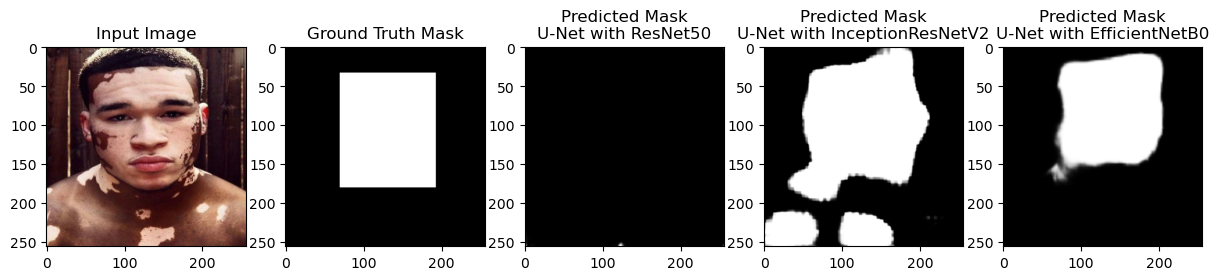

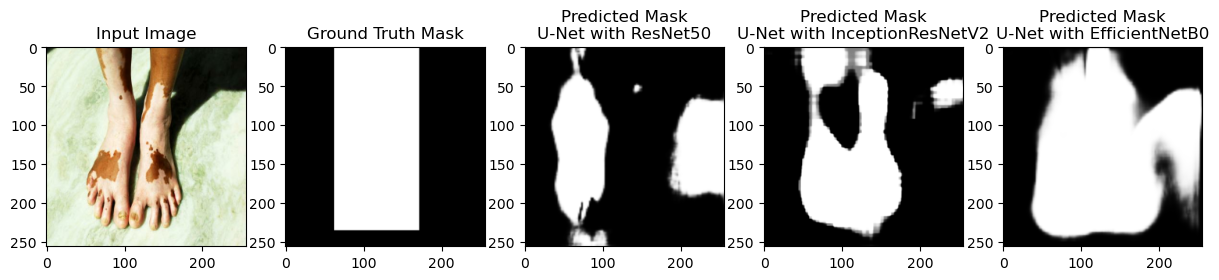

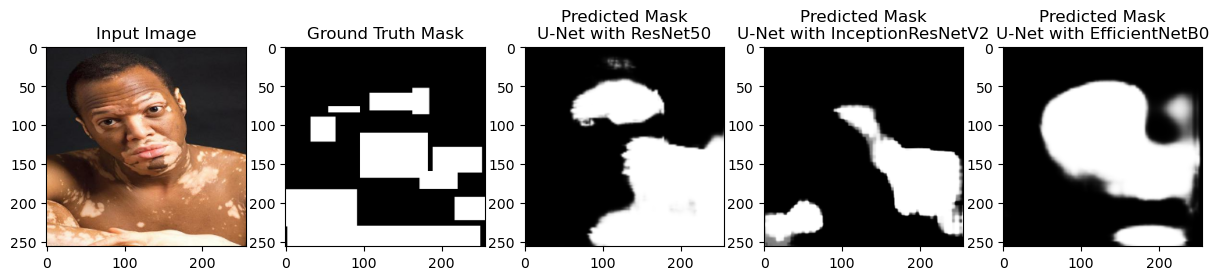

In [70]:
def show_segmentation_comparisons(original_images, ground_truth_masks, predicted_masks_dict, num_examples=3):
    for i in range(num_examples):
        plt.figure(figsize=(18, 6))
        
        plt.subplot(1, 3 + len(predicted_masks_dict), 1)
        plt.imshow(original_images[i])
        plt.title('Input Image')
        
        plt.subplot(1, 3 + len(predicted_masks_dict), 2)
        plt.imshow(ground_truth_masks[i, :, :, 0], cmap='gray')
        plt.title('Ground Truth Mask')
        
        for j, (model_name, predicted_masks) in enumerate(predicted_masks_dict.items()):
            plt.subplot(1, 3 + len(predicted_masks_dict), 3 + j)
            plt.imshow(predicted_masks[i, :, :, 0], cmap='gray')
            plt.title(f'Predicted Mask\n{model_name}')
        
        plt.show()

# Example usage
show_segmentation_comparisons(test_images, test_masks, predicted_masks)


In [71]:
import pandas as pd
from scipy.stats import ttest_rel, wilcoxon

# Collect metrics for statistical comparison
metrics = {
    'Model': [],
    'Test IoU Metric': [],
    'Test Dice Coefficient': []
}

for model_name, model in models.items():
    results = model.evaluate(test_images, test_masks, batch_size=8, verbose=0)
    metrics['Model'].append(model_name)
    metrics['Test IoU Metric'].append(results[2])
    metrics['Test Dice Coefficient'].append(results[3])

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

# Perform paired t-test and Wilcoxon test
iou_metrics = metrics_df['Test IoU Metric']
dice_metrics = metrics_df['Test Dice Coefficient']

t_stat_iou, p_value_iou = ttest_rel(iou_metrics, dice_metrics)
print(f'Paired t-test for IoU vs Dice Coefficient: t-statistic={t_stat_iou}, p-value={p_value_iou}')

w_stat_iou, p_value_iou = wilcoxon(iou_metrics, dice_metrics)
print(f'Wilcoxon test for IoU vs Dice Coefficient: statistic={w_stat_iou}, p-value={p_value_iou}')


                          Model  Test IoU Metric  Test Dice Coefficient
0           U-Net with ResNet50         0.671923               0.792042
1  U-Net with InceptionResNetV2         0.661274               0.792435
2     U-Net with EfficientNetB0         0.651118               0.783760
Paired t-test for IoU vs Dice Coefficient: t-statistic=-32.39338852454195, p-value=0.0009516274609337371
Wilcoxon test for IoU vs Dice Coefficient: statistic=0.0, p-value=0.25


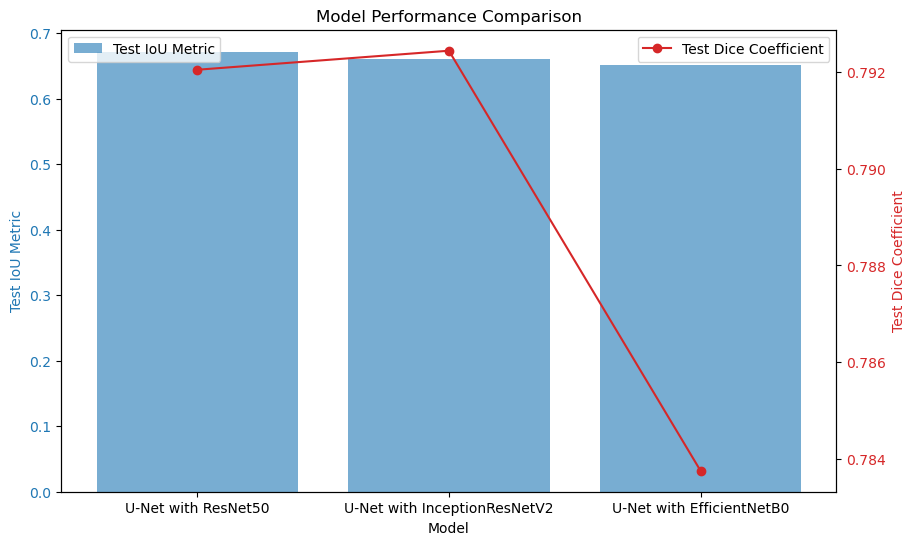

In [75]:
import matplotlib.pyplot as plt
import pandas as pd

# Your statistical analysis results
data = {
    'Model': ['U-Net with ResNet50', 'U-Net with InceptionResNetV2', 'U-Net with EfficientNetB0'],
    'Test IoU Metric': [0.671923, 0.661274, 0.651118],
    'Test Dice Coefficient': [0.792042, 0.792435, 0.783760]
}

metrics_df = pd.DataFrame(data)

# Set up the figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Test IoU Metric
ax1.set_xlabel('Model')
ax1.set_ylabel('Test IoU Metric', color='tab:blue')
ax1.bar(metrics_df['Model'], metrics_df['Test IoU Metric'], color='tab:blue', alpha=0.6, label='Test IoU Metric')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis to plot Test Dice Coefficient
ax2 = ax1.twinx()
ax2.set_ylabel('Test Dice Coefficient', color='tab:red')
ax2.plot(metrics_df['Model'], metrics_df['Test Dice Coefficient'], color='tab:red', marker='o', label='Test Dice Coefficient')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add titles and legends
plt.title('Model Performance Comparison')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()
